<a href="https://colab.research.google.com/github/ahmadrathore/Provisioning-SmartX-MicroBox/blob/master/2_CNN_Multivariate_Horizon_Style_FlowData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [823]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,TimeDistributed,RepeatVector
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout
tf.random.set_seed(123)
np.random.seed(123)

In [824]:
#df = pd.read_csv(r'merge-csv.com__602f0aa73c265.csv')
#df = pd.read_csv('merge-csv.com__602f0aa73c265.csv',index_col='Processing_time',
#                infer_datetime_format=True)
url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows.csv'

df = pd.read_csv(url,index_col='Processing_time',
                infer_datetime_format=True)

In [825]:
df.head()

,Measurement_boxname,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
Processing_time,,,,,,,,,,,,,,,
2020-12-01T00:05:24.998+09:00,smartx-microbox-gist-1,39846,9092,6,183,2438,2439,2439,0.07,161,11888,2788.26,2591.23,510252,170.018
2020-12-01T00:10:44.861+09:00,smartx-microbox-gist-1,39846,9092,6,396,2438,2439,2439,0.11,63,11856,2228.37,2094.46,882435,290.016
2020-12-01T00:15:33.979+09:00,smartx-microbox-gist-1,39846,9092,6,395,2438,2439,2439,0.13,102,13084,2209.62,2321.09,872801,290.017
2020-12-01T00:25:41.464+09:00,smartx-microbox-gist-1,39846,9092,6,459,2438,2439,2439,0.09,61,11550,1989.66,1919.81,913254,290.017
2020-12-01T00:35:18.114+09:00,smartx-microbox-gist-1,39846,9092,6,456,2438,2439,2439,0.09,87,11544,1981.21,1909.48,903430,290.011


In [826]:
df.describe()

,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
count,8576.000000,8576.0,8576.0,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,40807.862873,9092.0,6.0,362.090602,2315.889576,2317.284632,2316.846782,0.317004,76.953708,10271.796525,2104.136580,2048.747845,761531.681087,279.171818
std,3907.567979,0.0,0.0,56.159077,395.897535,394.644232,395.614646,1.226467,19.597907,1867.873236,175.951136,231.740512,131589.840309,34.988489
min,33560.000000,9092.0,6.0,22.000000,499.000000,501.000000,501.000000,0.000000,59.000000,5971.000000,1387.150000,1291.840000,44072.000000,10.014000
25%,39846.000000,9092.0,6.0,340.000000,2438.000000,2439.000000,2439.000000,0.000000,62.000000,8740.000000,1973.480000,1867.347500,686703.750000,290.015000
50%,39846.000000,9092.0,6.0,369.000000,2438.000000,2439.000000,2439.000000,0.050000,69.000000,10587.000000,2094.890000,2032.635000,709585.000000,290.016000
75%,40442.000000,9092.0,6.0,398.000000,2439.000000,2439.000000,2439.000000,0.100000,88.000000,11718.000000,2226.530000,2229.402500,882164.750000,290.017000
max,59584.000000,9092.0,6.0,514.000000,2439.000000,2439.000000,2439.000000,21.950000,264.000000,14764.000000,2899.900000,2856.150000,923288.000000,290.056000


In [827]:
#df.drop_duplicates(subset=['Processing_time'], keep=False,inplace=True)

In [828]:
Measurement_boxname_le = preprocessing.LabelEncoder()
df['Measurement_boxname_le'] = Measurement_boxname_le.fit_transform(df['Measurement_boxname']) 

In [829]:
df = df[['min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']]

In [830]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [831]:
validate = df[['min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(30)
df.drop(df.tail(30).index,inplace=True)

In [832]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(df[['Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']])
dataY = y_scaler.fit_transform(df[['total_data_bytes']])

In [833]:
#hist_window = 12
#horizon = 10
hist_window = 80
horizon = 30

TRAIN_SPLIT = 5500
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi = custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [834]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.         0.49756098 0.67292164 0.92620063 0.83064738 0.53022238]
 [0.         0.0195122  0.66928238 0.5560866  0.51308245 0.95353474]
 [0.         0.2097561  0.80893893 0.54369195 0.65795782 0.94257725]
 [0.         0.0097561  0.63448197 0.39828789 0.40143578 0.98858756]
 [0.         0.13658537 0.63379961 0.39270203 0.39483223 0.97741397]
 [0.         0.20487805 0.66666667 0.49240787 0.48279433 0.96592077]
 [0.         0.01463415 0.64426248 0.55013056 0.65527932 0.94442549]
 [0.         0.04390244 0.70214944 0.51846637 0.54657325 0.95507134]
 [0.         0.10731707 0.59683839 0.655647   0.66667732 0.94831418]
 [0.         0.0097561  0.64630956 0.45051066 0.49403891 0.96630407]
 [0.         0.24390244 0.66518822 0.48702694 0.55472381 0.55379224]
 [0.         0.0097561  0.80893893 0.41813254 0.42267198 0.96750514]
 [0.         0.0097561  0.59126578 0.41946786 0.50295018 0.97082287]
 [0.         0.0097561  0.80893893 0.58135184 0.68869342 0.94239072]
 [0.

In [835]:
#BATCH_SIZE = 256
#BUFFER_SIZE = 150
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [836]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_multi.shape[1], x_train_multi.shape[2])))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mse')

In [837]:
model_path = r'CNN_Multivariate.h5'

In [838]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose=1,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'), tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 4s 33ms/step - loss: 0.4583 - val_loss: 0.0212
Epoch 2/150
100/100 [==============================] - 3s 31ms/step - loss: 0.0971 - val_loss: 0.0218
Epoch 3/150
100/100 [==============================] - 3s 31ms/step - loss: 0.0633 - val_loss: 0.0096
Epoch 4/150
100/100 [==============================] - 3s 31ms/step - loss: 0.0480 - val_loss: 0.0097
Epoch 5/150
100/100 [==============================] - 3s 31ms/step - loss: 0.0422 - val_loss: 0.0120
Epoch 6/150
100/100 [==============================] - 3s 32ms/step - loss: 0.0366 - val_loss: 0.0121
Epoch 7/150
100/100 [==============================] - 3s 31ms/step - loss: 0.0358 - val_loss: 0.0093
Epoch 8/150
100/100 [==============================] - 3s 31ms/step - loss: 0.0296 - val_loss: 0.0095
Epoch 9/150
100/100 [==============================] - 3s 31ms/step - loss: 0.0287 - val_loss: 0.0094
Epoch 10/150
100/100 [==============================] - 3s 32ms/step - loss: 0.026

In [839]:
Trained_model = tf.keras.models.load_model(model_path)

In [840]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 78, 64)            1216      
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 39, 64)            0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 39, 64)            0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 2496)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 30)                74910     
_________________________________________________________________
dropout_61 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 30)              

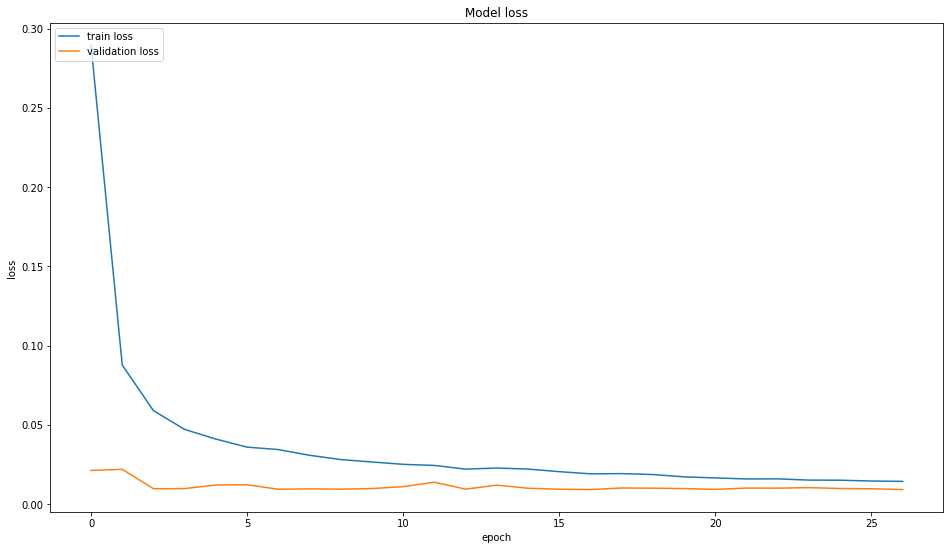

In [841]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [842]:
data_val = x_scaler.fit_transform(df[['Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']].tail(80))

In [843]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [844]:
Predicted_results = Trained_model.predict(val_rescaled)

In [845]:
Predicted_results

array([[0.6514803 , 0.6360878 , 0.7127615 , 0.7714385 , 0.74021786,
        0.8256172 , 0.74459696, 0.7744796 , 0.80867046, 0.7662349 ,
        0.6978717 , 0.7186198 , 0.7025342 , 0.6782285 , 0.70060265,
        0.8247764 , 0.79037607, 0.76970375, 0.7336728 , 0.7289065 ,
        0.7763818 , 0.74504095, 0.7014571 , 0.6852271 , 0.69360733,
        0.59992737, 0.68516505, 0.74082446, 0.7942574 , 0.7669015 ]],
      dtype=float32)

In [846]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [847]:
Predicted_results_Inv_trans

array([[616863.94, 603330.56, 670743.4 , 722333.06, 694883.4 , 769967.9 ,
        698733.56, 725006.9 , 755068.  , 717758.  , 657651.94, 675894.06,
        661751.3 , 640381.4 , 660053.06, 769228.6 , 738983.3 , 720807.9 ,
        689128.9 , 684938.3 , 726679.3 , 699123.94, 660804.3 , 646534.6 ,
        653902.7 , 571537.75, 646480.06, 695416.75, 742395.8 , 718344.06]],
      dtype=float32)

In [848]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [849]:
timeseries_evaluation_metrics_func(validate['total_data_bytes'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 9479415658.551693
MAE is : 79194.60625
RMSE is : 97362.29074211275
MAPE is : 12.200617173476202
R2 is : -0.12711346391524447



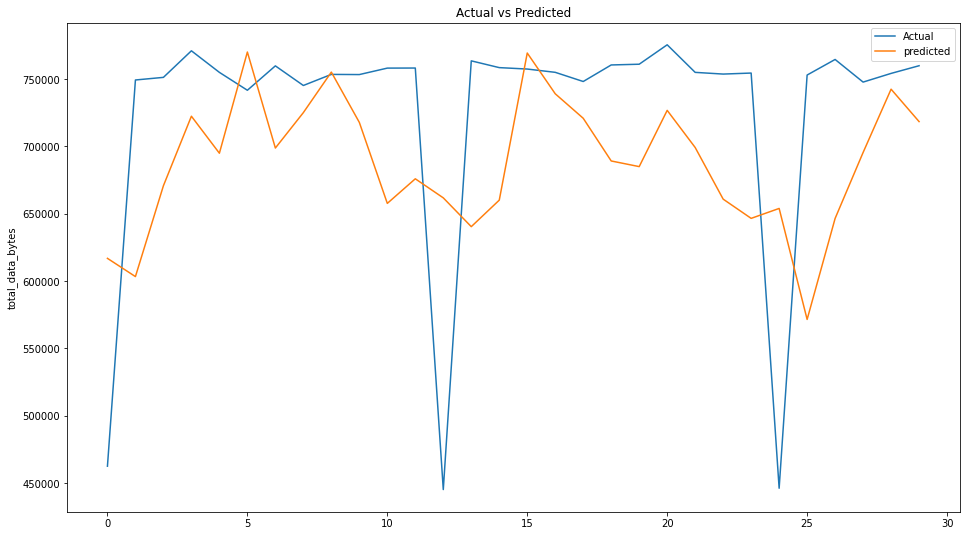

In [850]:


plt.plot( list(validate['total_data_bytes']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("total_data_bytes")
plt.legend(('Actual','predicted'))
plt.show()
